In [170]:
#pip install numpy matplotlib opencv-python

In [171]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load Data

In [172]:
def load_sqlite_to_dataframe(sqlite_file, table_name):
    # Connect to the SQLite database
    conn = sqlite3.connect(sqlite_file)
    # Load data into a DataFrame
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    # Close the connection
    conn.close()
    return df

In [173]:
# GH data
df_metrics_gh = load_sqlite_to_dataframe('data/GH/tracking.db', 'metrics')
df_metrics_gh['filter'] = 'GH'
df_tracks_gh = load_sqlite_to_dataframe('data/GH/tracking.db', 'tracks')
df_tracks_gh['filter'] = 'GH'

In [174]:
# Kalman data
df_metrics_kalman = load_sqlite_to_dataframe('data/Kalman/tracking.db', 'metrics')
df_metrics_kalman['filter'] = 'Kalman'
df_tracks_kalman = load_sqlite_to_dataframe('data/Kalman/tracking.db', 'tracks')
df_tracks_kalman['filter'] = 'Kalman'

In [175]:
# Particles data
df_metrics_particles = load_sqlite_to_dataframe('data/Particle/tracking.db', 'metrics')
df_metrics_particles['filter'] = 'Particle'
df_tracks_particles = load_sqlite_to_dataframe('data/Particle/tracking.db', 'tracks')
df_tracks_particles['filter'] = 'Particle'

In [176]:
# Unscented data
df_metrics_unscented = load_sqlite_to_dataframe('data/Unscented/tracking.db', 'metrics')
df_metrics_unscented['filter'] = 'Unscented'
df_tracks_unscented = load_sqlite_to_dataframe('data/Unscented/tracking.db', 'tracks')
df_tracks_unscented['filter'] = 'Unscented'

In [177]:
df_metrics = pd.concat([df_metrics_gh, df_metrics_kalman, df_metrics_unscented, df_metrics_particles])
df_metrics = df_metrics.reset_index().drop('index', axis=1)

df_metrics['timestamp'] = pd.to_datetime(df_metrics['timestamp'])
df_metrics['value'] = df_metrics['value'].astype(float)

df_metrics

,metric,value,frame,timestamp,filter
0,FPS,1.0,0,2024-07-08 00:48:03,GH
1,FPS,31087.0,1,2024-07-08 00:48:03,GH
2,FPS,16.0,2,2024-07-08 00:48:03,GH
3,FPS,2291.0,3,2024-07-08 00:48:03,GH
4,FPS,24.0,4,2024-07-08 00:48:03,GH
...,...,...,...,...,...
6127,Trackers Delta,0.0,336,2024-07-08 00:46:07,Particle
6128,Trackers Delta,0.0,337,2024-07-08 00:46:07,Particle
6129,Trackers Delta,2.0,338,2024-07-08 00:46:07,Particle
6130,Trackers Delta,0.0,339,2024-07-08 00:46:07,Particle


In [178]:
df_tracks = pd.concat([df_tracks_gh, df_tracks_kalman, df_tracks_unscented, df_tracks_particles])
df_tracks = df_tracks.reset_index().drop('index', axis=1)

df_tracks['timestamp'] = df_tracks['timestamp'].astype(int)

df_tracks['score'] = df_tracks['score'].apply(lambda x: None if isinstance(x, bytes) else x)
df_tracks['score'] = df_tracks['score'].astype(float)
#df_tracks[df_tracks['tracker'] == '0224473a-65a5-43e8-b700-a186ca32bdaf']
df_tracks.head()

,tracker,position,direction,cell,frame,roi,score,timestamp,filter
0,13bb4ce8-0158-46ed-9bad-0f2a6c496fbb,"(992, 270)",None,216,2,None,0.776015,27809989631875,GH
1,442ca72e-5b39-4377-9352-29d05e4e1018,"(1006, 376)",None,313,2,None,0.764777,27809990506125,GH
2,9ede2251-cc87-4349-a2d8-c04d473861d6,"(473, 477)",None,363,2,None,0.756263,27809992515916,GH
3,ebd6df72-0b91-48c9-85e5-07cdd8191c1a,"(794, 670)",None,531,2,None,0.746706,27809993840708,GH
4,a94bccd2-780a-44a9-847e-553a0b28fa91,"(526, 344)",None,269,2,None,0.727562,27809995298375,GH


# FPS

GH: 3509.798816568047
Kalman: 1146.508875739645
Particle: 886.8461538461538
Unscented: 91.20118343195266


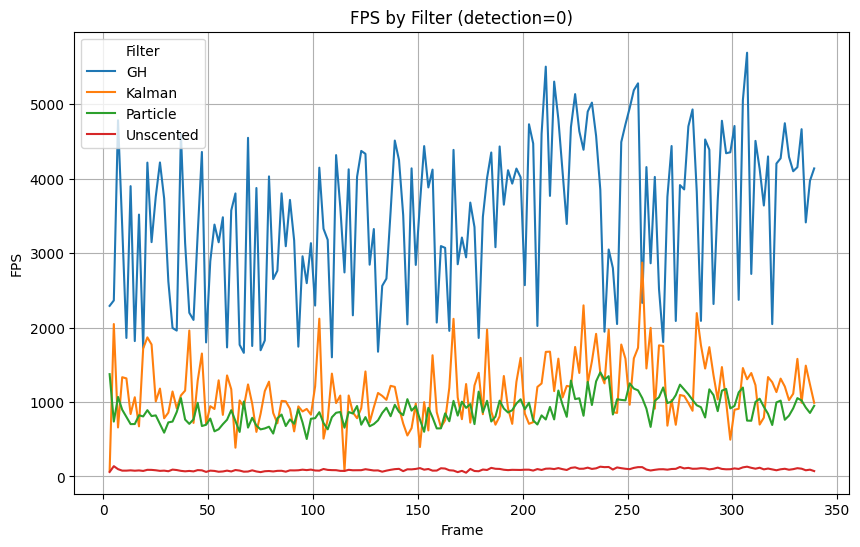

GH: 26.941176470588236
Kalman: 19.388235294117646
Particle: 22.11764705882353
Unscented: 17.41176470588235


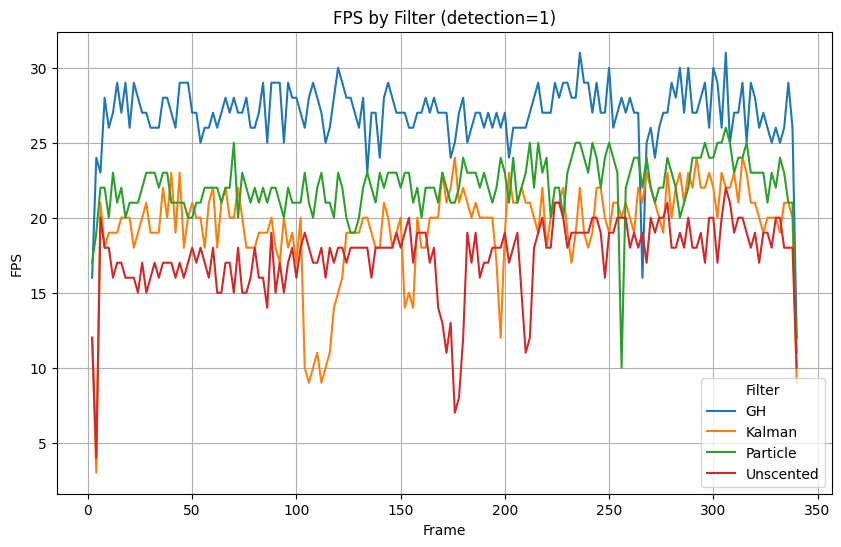

In [179]:
df_fps = df_metrics[(df_metrics['metric'] == 'FPS') & (df_metrics['frame'] > 1)]
df_fps = df_fps.reset_index().drop('index', axis=1)
df_fps['detection'] = df_fps['frame'] % 2 == 0

def plot_fps(df, detection: int):
  df = df.copy()
  df = df[df['detection'] == detection].reset_index().drop('index', axis=1)

  # Plotting the data
  plt.figure(figsize=(10, 6))

  # Group by 'filter' and plot each group
  for key, grp in df.groupby('filter'):
    print(key + ': ' + str(np.mean(grp['value'])))
    plt.plot(grp['frame'], grp['value'], label=key)

  plt.xlabel('Frame')
  plt.ylabel('FPS')
  plt.title(f'FPS by Filter (detection={detection})')
  plt.legend(title='Filter')
  plt.grid(True)
  plt.show()


plot_fps(df_fps, 0)
plot_fps(df_fps, 1)

Observando la gran diferencia de velocidades en ambos escenarios es notable que la detección genera un procesamiento muy lento. Luego, observando el escenario sin detección (solo predicción), GH es el más rápido, seguido por Kalman, Particles y, por último, Unscented.

Medias:
* GH: 3666.153846153846
* Kalman: 1153.2662721893491
* Particles: 365.94674556213016
* Unscented: 88.38461538461539

# Detections

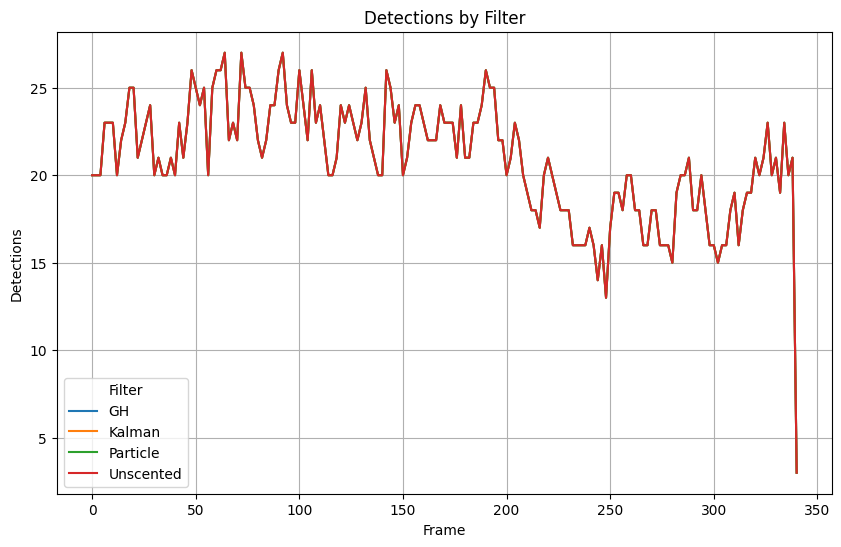

In [180]:
df_detections = df_metrics[df_metrics['metric'] == 'Detections']
df_detections = df_detections.reset_index().drop('index', axis=1)
df_detections['detection'] = df_detections['frame'] % 2 == 0

# Plotting the data
plt.figure(figsize=(10, 6))

# Group by 'filter' and plot each group
for key, grp in df_detections.groupby('filter'):
  plt.plot(grp['frame'], grp['value'], label=key)

plt.xlabel('Frame')
plt.ylabel('Detections')
plt.title(f'Detections by Filter')
plt.legend(title='Filter')
plt.grid(True)
plt.show()


Es esperado que la metrica de objetos detectados sea exactamente igual en todas las pruebas dado que esta etapa es independiente. Con este gráfico confirmamos que el modelo de detecciones no tuvo diferencias entre las ejecuciones.

# Active Trackers

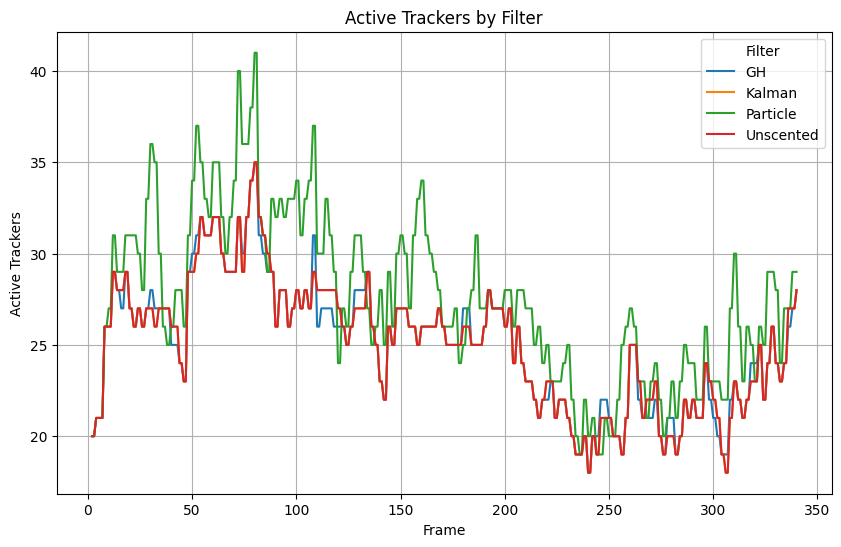

In [181]:
df_active = df_metrics[(df_metrics['metric'] == 'Active Trackers') & (df_metrics['frame'] > 1)]
df_active = df_active.reset_index().drop('index', axis=1)

# Plotting the data
plt.figure(figsize=(10, 6))

# Group by 'filter' and plot each group
for key, grp in df_active.groupby('filter'):
  plt.plot(grp['frame'], grp['value'], label=key)

plt.xlabel('Frame')
plt.ylabel('Active Trackers')
plt.title(f'Active Trackers by Filter')
plt.legend(title='Filter')
plt.grid(True)
plt.show()

Estamos generando erróneamente más trackers en Particles. Eso significa que las predicciones no están bien y se generan nuevos trackers en las detecciones. Kalman y Unscented Kalman tiene el mismo comportamiento.

# Trackers Delta

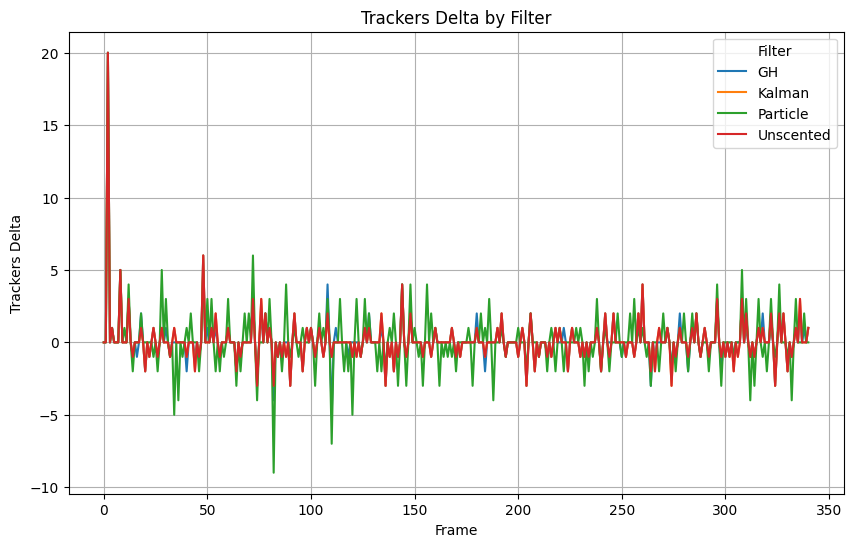

In [182]:
df_delta = df_metrics[(df_metrics['metric'] == 'Trackers Delta')]
df_delta = df_delta.reset_index().drop('index', axis=1)

# Plotting the data
plt.figure(figsize=(10, 6))

# Group by 'filter' and plot each group
for key, grp in df_delta.groupby('filter'):
  plt.plot(grp['frame'], grp['value'], label=key)

plt.xlabel('Frame')
plt.ylabel('Trackers Delta')
plt.title(f'Trackers Delta by Filter')
plt.legend(title='Filter')
plt.grid(True)
plt.show()

Por lo comentado mas arriba (sobre los trackers activos de Particles) es esperable que haya mayor movimiento (generación y eliminación) de trackers.

# Prediction Errors

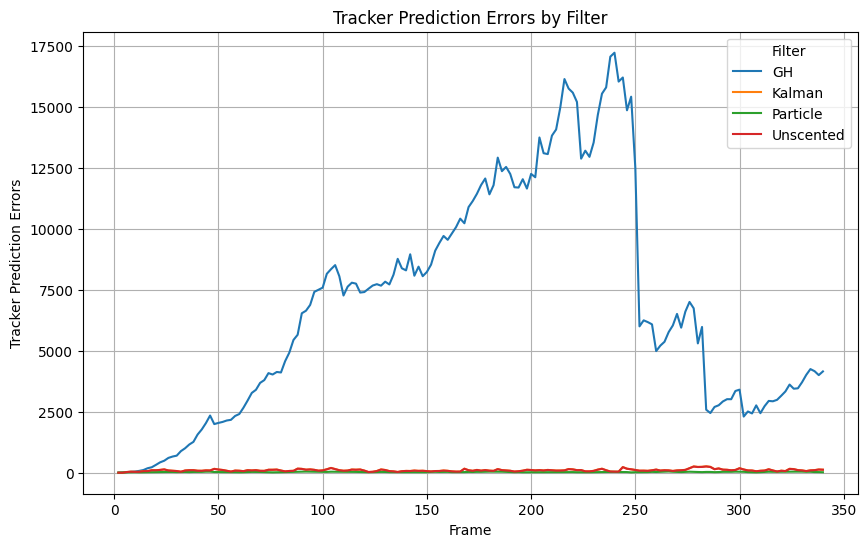

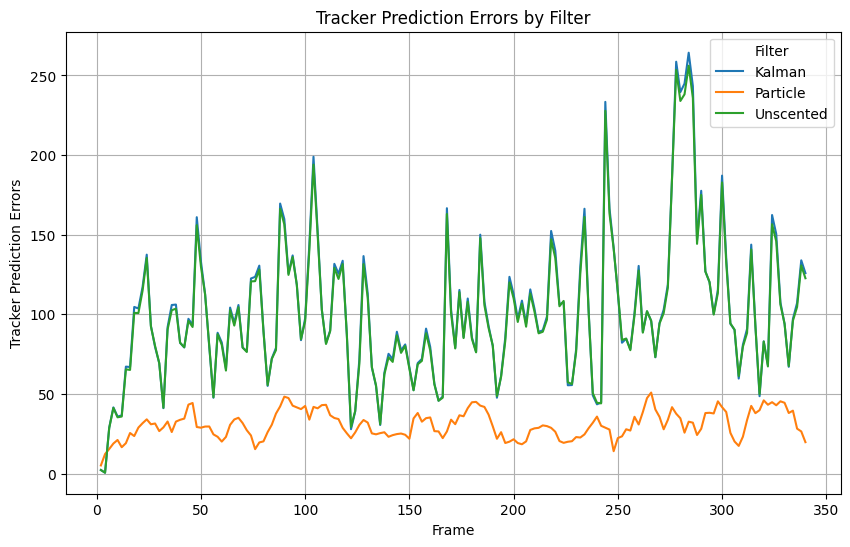

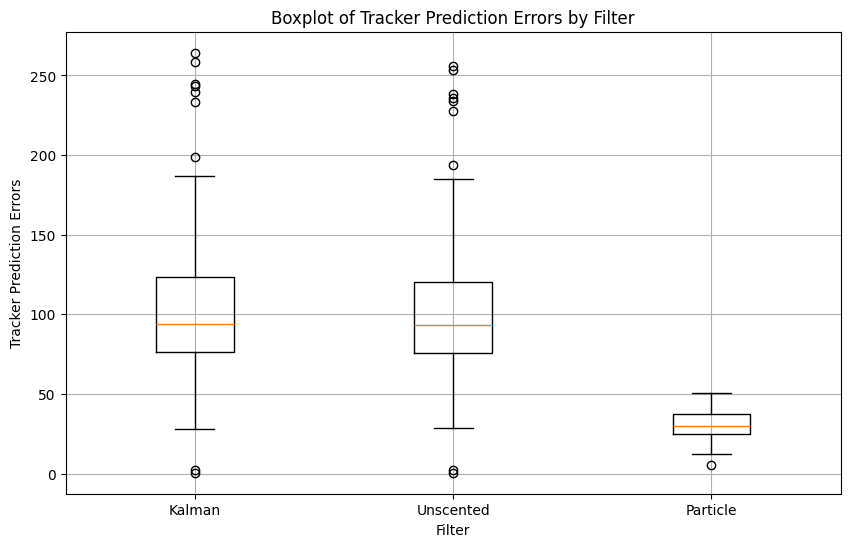

In [183]:
df_errors = df_metrics[(df_metrics['metric'] == 'Tracker Errors') & (df_metrics['frame'] > 1) & (df_metrics['frame'] % 2 == 0)]
df_errors = df_errors.reset_index().drop('index', axis=1)

# Plotting the data
plt.figure(figsize=(10, 6))

# Group by 'filter' and plot each group
for key, grp in df_errors.groupby('filter'):
  plt.plot(grp['frame'], grp['value'], label=key)

plt.xlabel('Frame')
plt.ylabel('Tracker Prediction Errors')
plt.title(f'Tracker Prediction Errors by Filter')
plt.legend(title='Filter')
plt.grid(True)
plt.show()

df_errors = df_errors[(df_errors['filter'] != 'GH')]
df_errors = df_errors.reset_index().drop('index', axis=1)

# Plotting the data
plt.figure(figsize=(10, 6))

# Group by 'filter' and plot each group
for key, grp in df_errors.groupby('filter'):
  plt.plot(grp['frame'], grp['value'], label=key)

plt.xlabel('Frame')
plt.ylabel('Tracker Prediction Errors')
plt.title(f'Tracker Prediction Errors by Filter')
plt.legend(title='Filter')
plt.grid(True)
plt.show()

# Create a dictionary to store data for each filter
filter_data = {}
for f in df_errors['filter'].unique():
    filter_data[f] = df_errors[df_errors['filter'] == f]['value']

# Plot all boxplots on the same figure
plt.figure(figsize=(10, 6))
plt.boxplot(filter_data.values(), labels=filter_data.keys())
plt.xlabel('Filter')
plt.ylabel('Tracker Prediction Errors')
plt.title('Boxplot of Tracker Prediction Errors by Filter')
plt.grid(True)
plt.show()

Claramente las precicciones realizadas por Particles son mejores. Kalman y Unscented Kalman no presentan diferencias. Es esperable que GH sea el pero dada la simpleza del modelo.

# Tracker Lifetime

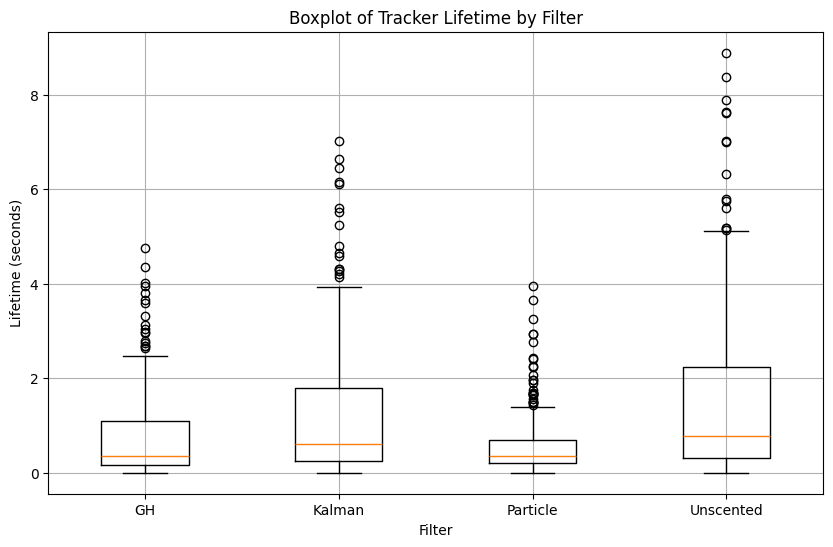

In [184]:
# Group by 'filter' and 'tracker' and calculate min, max, and lifetime
df_lifetime = df_tracks.groupby(['filter', 'tracker']).agg(
    min_timestamp=('timestamp', 'min'),
    max_timestamp=('timestamp', 'max'),
)

df_lifetime['lifetime'] = (df_lifetime['max_timestamp'] - df_lifetime['min_timestamp']) / 1000000000 #seconds
df_lifetime = df_lifetime.reset_index()

# Create a dictionary to store data for each filter
filter_data = {}
for f in df_lifetime['filter'].unique():
    filter_data[f] = df_lifetime[df_lifetime['filter'] == f]['lifetime']

# Plot all boxplots on the same figure
plt.figure(figsize=(10, 6))
plt.boxplot(filter_data.values(), labels=filter_data.keys())
plt.xlabel('Filter')
plt.ylabel('Lifetime (seconds)')
plt.title('Boxplot of Tracker Lifetime by Filter')
plt.grid(True)
plt.show()

Unscented tiene un mayor tiempo de vida de los trackers, eso significaría que sigue durante más tiempo a las personas. No tenemos un baseline para esta métrica, pero entendemos que mientras más tiempo estuvo vivo el tracker, mejor fue la predicción (no fue descartado por mala predicción).

El bajo tiempo de vida de los trackers de Particles confirma lo expuesto antes, las predicciones son malas y los trackers están continuamente descartandose.

# Detection Score

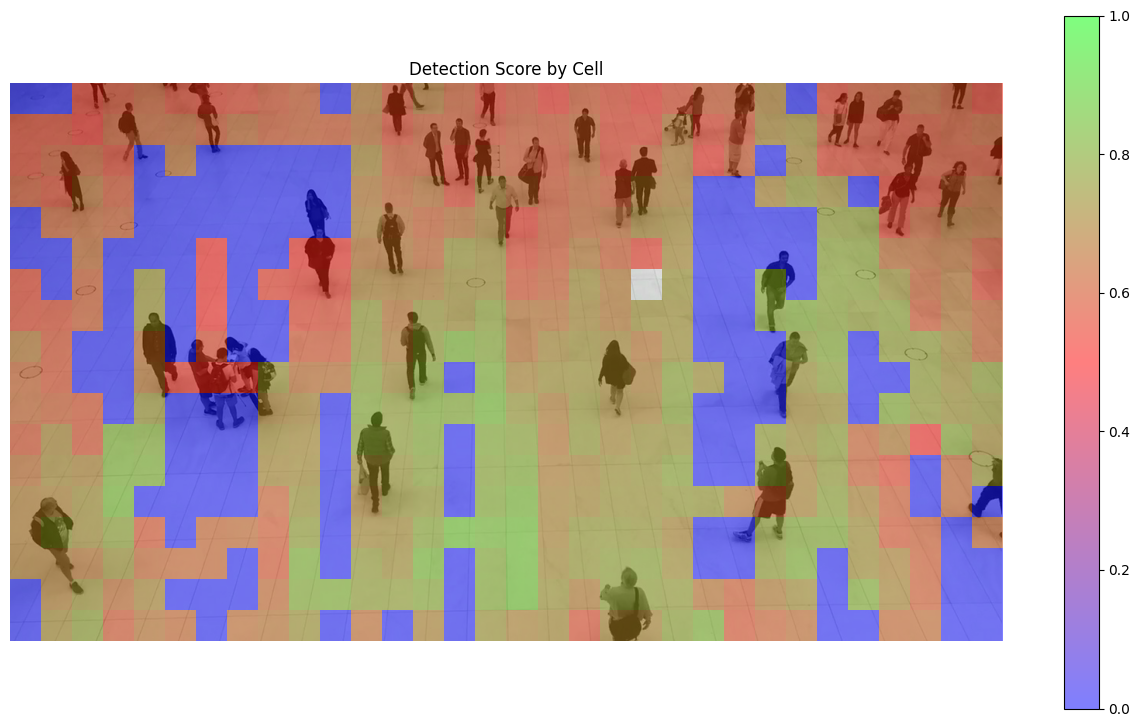

In [185]:
df_scores = df_tracks.copy()

# Agrupar por celda y calcular la media del score
df_scores_grouped = df_scores[['cell','score']].groupby('cell').mean().reset_index()

# Tamaño de la imagen
img_width, img_height = 1280, 720

# Tamaño de las celdas del heatmap
cell_size = 40

# Ruta de la imagen en el disco
image_path = 'assets/frame.jpg'

# Cargar la imagen desde el disco
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB para matplotlib
img_height, img_width = image.shape[:2]

# Convertir el dataframe agrupado en una matriz de datos para el heatmap
heatmap_data = np.zeros((img_height // cell_size, img_width // cell_size))

for index, row in df_scores_grouped.iterrows():
    cell = int(row['cell'])
    score = float(row['score'])
    i, j = cell // (img_width // cell_size), cell % (img_width // cell_size)
    heatmap_data[i, j] = score

# Crear el heatmap con matplotlib
fig, ax = plt.subplots(figsize=(16, 9))  # Aumentar el tamaño de la figura
ax.imshow(image, alpha=1)
cax = ax.imshow(heatmap_data, cmap='brg', alpha=0.5, extent=[0, img_width, img_height, 0], vmin=0, vmax=1)  # Ajustar la extensión

# Añadir colorbar
fig.colorbar(cax)

plt.title('Detection Score by Cell')
plt.axis('off')  # Desactivar los ejes

plt.show()

Tenemos un umbral de 0.5 establecido en el programa, debajo de eso es ignorado. En este grafico, lo mejor es tener verde (altos scores de detección).

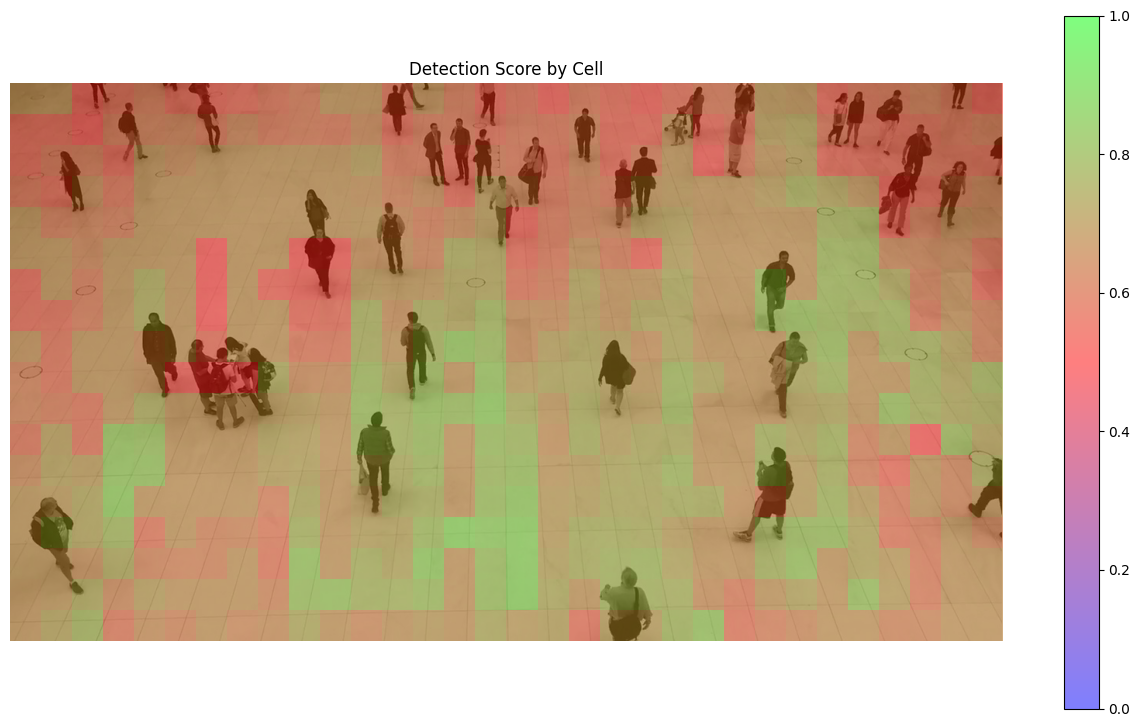

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.impute import KNNImputer

# Load your data into df_tracks
# df_tracks = pd.read_csv('your_data.csv')

df_scores = df_tracks.copy()

# Agrupar por celda y calcular la media del score
df_scores_grouped = df_scores[['cell', 'score']].groupby('cell').mean().reset_index()

# Tamaño de la imagen
img_width, img_height = 1280, 720

# Tamaño de las celdas del heatmap
cell_size = 40

# Ruta de la imagen en el disco
image_path = 'assets/frame.jpg'

# Cargar la imagen desde el disco
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB para matplotlib
img_height, img_width = image.shape[:2]

# Create a full grid of cells
num_cells_x = img_width // cell_size
num_cells_y = img_height // cell_size
all_cells = pd.DataFrame({'cell': np.arange(num_cells_x * num_cells_y)})

# Merge with the actual scores, filling missing cells with NaN
df_scores_full = all_cells.merge(df_scores_grouped, on='cell', how='left')

# Use KNNImputer to fill the missing scores
imputer = KNNImputer(n_neighbors=3)
df_scores_full['score'] = imputer.fit_transform(df_scores_full[['score']])

# Convert the dataframe to a heatmap matrix
heatmap_data = np.zeros((num_cells_y, num_cells_x))

for index, row in df_scores_full.iterrows():
    cell = int(row['cell'])
    score = float(row['score'])
    i, j = cell // num_cells_x, cell % num_cells_x
    heatmap_data[i, j] = score

# Crear el heatmap con matplotlib
fig, ax = plt.subplots(figsize=(16, 9))  # Aumentar el tamaño de la figura
ax.imshow(image, alpha=1)
cax = ax.imshow(heatmap_data, cmap='brg', alpha=0.5, extent=[0, img_width, img_height, 0], vmin=0, vmax=1)  # Ajustar la extensión

# Añadir colorbar
fig.colorbar(cax)

plt.title('Detection Score by Cell')
plt.axis('off')  # Desactivar los ejes

plt.show()


# Cell Traffic

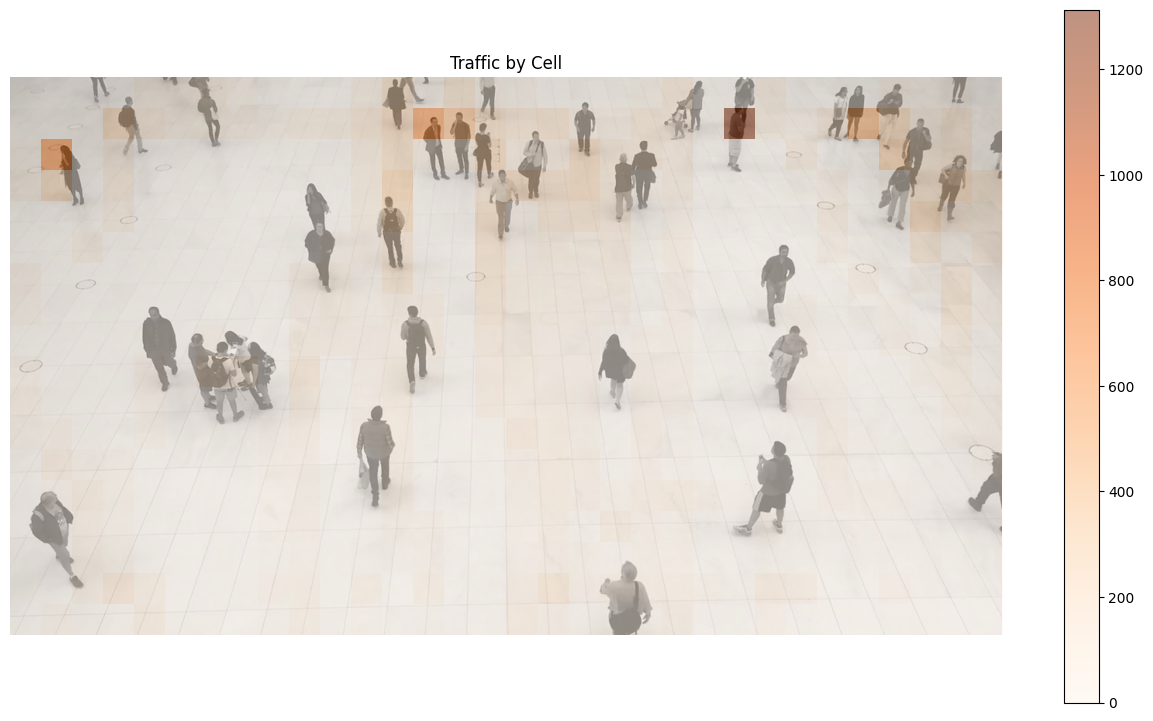

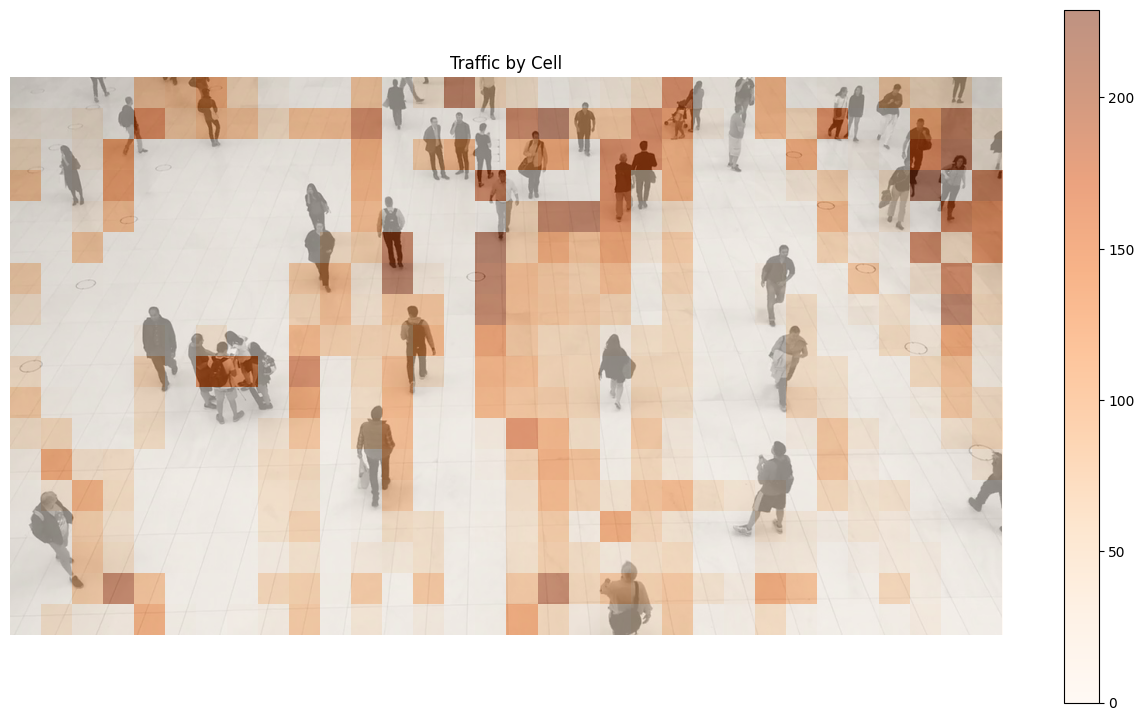

In [188]:
df_traffic = df_tracks.copy()

# Agrupar por celda y calcular la media del score
df_traffic_grouped = df_traffic.groupby('cell').size().reset_index(name='score')

# Tamaño de la imagen
img_width, img_height = 1280, 720

# Tamaño de las celdas del heatmap
cell_size = 40

# Ruta de la imagen en el disco
image_path = 'assets/frame.jpg'

# Cargar la imagen desde el disco
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB para matplotlib

# Convertir el dataframe agrupado en una matriz de datos para el heatmap
heatmap_data = np.zeros((img_height // cell_size, img_width // cell_size))

for index, row in df_traffic_grouped.iterrows():
    cell = int(row['cell'])
    score = float(row['score'])
    i, j = cell // (img_width // cell_size), cell % (img_width // cell_size)
    heatmap_data[i, j] = score

# Crear el heatmap con matplotlib
fig, ax = plt.subplots(figsize=(16, 9))  # Aumentar el tamaño de la figura
ax.imshow(image, alpha=1)
cax = ax.imshow(heatmap_data, cmap='Oranges', alpha=0.5, extent=[0, img_width, img_height, 0])  # Ajustar la extensión

# Añadir colorbar
fig.colorbar(cax)

plt.title('Traffic by Cell')
plt.axis('off')  # Desactivar los ejes

plt.show()

# Calcular Q1 (primer cuartil) y Q3 (tercer cuartil)
Q1 = df_traffic_grouped['score'].quantile(0.25)
Q3 = df_traffic_grouped['score'].quantile(0.75)

# Calcular IQR (rango intercuartílico)
IQR = Q3 - Q1

# Definir los límites inferior y superior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Eliminar los outliers
df_traffic_no_outliers = df_traffic_grouped[(df_traffic_grouped['score'] >= lower_bound) & (df_traffic_grouped['score'] <= upper_bound)]

# Convertir el dataframe agrupado en una matriz de datos para el heatmap
heatmap_data = np.zeros((img_height // cell_size, img_width // cell_size))

for index, row in df_traffic_no_outliers.iterrows():
    cell = int(row['cell'])
    score = float(row['score'])
    i, j = cell // (img_width // cell_size), cell % (img_width // cell_size)
    heatmap_data[i, j] = score

# Crear el heatmap con matplotlib
fig, ax = plt.subplots(figsize=(16, 9))  # Aumentar el tamaño de la figura
ax.imshow(image, alpha=1)
cax = ax.imshow(heatmap_data, cmap='Oranges', alpha=0.5, extent=[0, img_width, img_height, 0])  # Ajustar la extensión

# Añadir colorbar
fig.colorbar(cax)

plt.title('Traffic by Cell')
plt.axis('off')  # Desactivar los ejes

plt.show()


